In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [10]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 60
LABELS = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
INV_LABELS = {v: k for k, v in LABELS.items()}

In [11]:
os.makedirs('models', exist_ok=True)

In [12]:
def parse_xml_dataset(annot_path, img_dir):
    image_paths, labels, bboxes = [], [], []
    xml_files = sorted([f for f in os.listdir(annot_path) if f.endswith('.xml')])
    
    for file in tqdm(xml_files, desc="Parsing XML"):
        tree = ET.parse(os.path.join(annot_path, file))
        root = tree.getroot()
        
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        
        
        obj = root.find('object')
        if obj is not None:
            name = obj.find('name').text
            if name not in LABELS: continue
            
            box = obj.find('bndbox')
            
            bboxes.append([
                int(box.find('xmin').text) / width,
                int(box.find('ymin').text) / height,
                int(box.find('xmax').text) / width,
                int(box.find('ymax').text) / height
            ])
            labels.append(LABELS[name])
            image_paths.append(os.path.join(img_dir, root.find('filename').text))

    return np.array(image_paths), tf.keras.utils.to_categorical(labels, 3), np.array(bboxes)

images_path = "DL lab assessment dataset/images"
annots_path = "DL lab assessment dataset/annotations"
X_paths, y_class, y_box = parse_xml_dataset(annots_path, images_path)

Parsing XML: 100%|██████████| 853/853 [00:00<00:00, 1973.18it/s]


In [13]:
def build_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, 
                             input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    base_model.trainable = False 

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)


    class_output = Dense(3, activation="softmax", name="class_output")(x)
    
    
    bbox_output = Dense(4, activation="sigmoid", name="bbox_output")(x)

    model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
        metrics={'class_output': 'accuracy', 'bbox_output': 'mae'}
    )
    return model

model = build_model()

In [23]:
def preprocess(path, label, bbox):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    return img, {'class_output': label, 'bbox_output': bbox}


X_train, X_test, yc_train, yc_test, yb_train, yb_test = train_test_split(
    X_paths, y_class, y_box, test_size=0.2, random_state=42
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, yc_train, yb_train))
train_ds = train_ds.map(preprocess).shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, yc_test, yb_test))
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds, epochs=EPOCHS)
model.save("models/face_mask_detector.h5")

Epoch 1/60
22/22 [==============================] - 2s 50ms/step - loss: 0.0698 - class_output_loss: 0.0379 - bbox_output_loss: 0.0319 - class_output_accuracy: 0.9985 - bbox_output_mae: 0.1367
Epoch 2/60
22/22 [==============================] - 1s 57ms/step - loss: 0.0663 - class_output_loss: 0.0350 - bbox_output_loss: 0.0313 - class_output_accuracy: 0.9971 - bbox_output_mae: 0.1342
Epoch 3/60
22/22 [==============================] - 1s 50ms/step - loss: 0.0631 - class_output_loss: 0.0322 - bbox_output_loss: 0.0310 - class_output_accuracy: 0.9971 - bbox_output_mae: 0.1334
Epoch 4/60
22/22 [==============================] - 1s 49ms/step - loss: 0.0678 - class_output_loss: 0.0358 - bbox_output_loss: 0.0321 - class_output_accuracy: 0.9985 - bbox_output_mae: 0.1378
Epoch 5/60
22/22 [==============================] - 1s 54ms/step - loss: 0.0640 - class_output_loss: 0.0338 - bbox_output_loss: 0.0302 - class_output_accuracy: 0.9971 - bbox_output_mae: 0.1333
Epoch 6/60
22/22 [=================

1/1 [==============================] - 0s 25ms/step


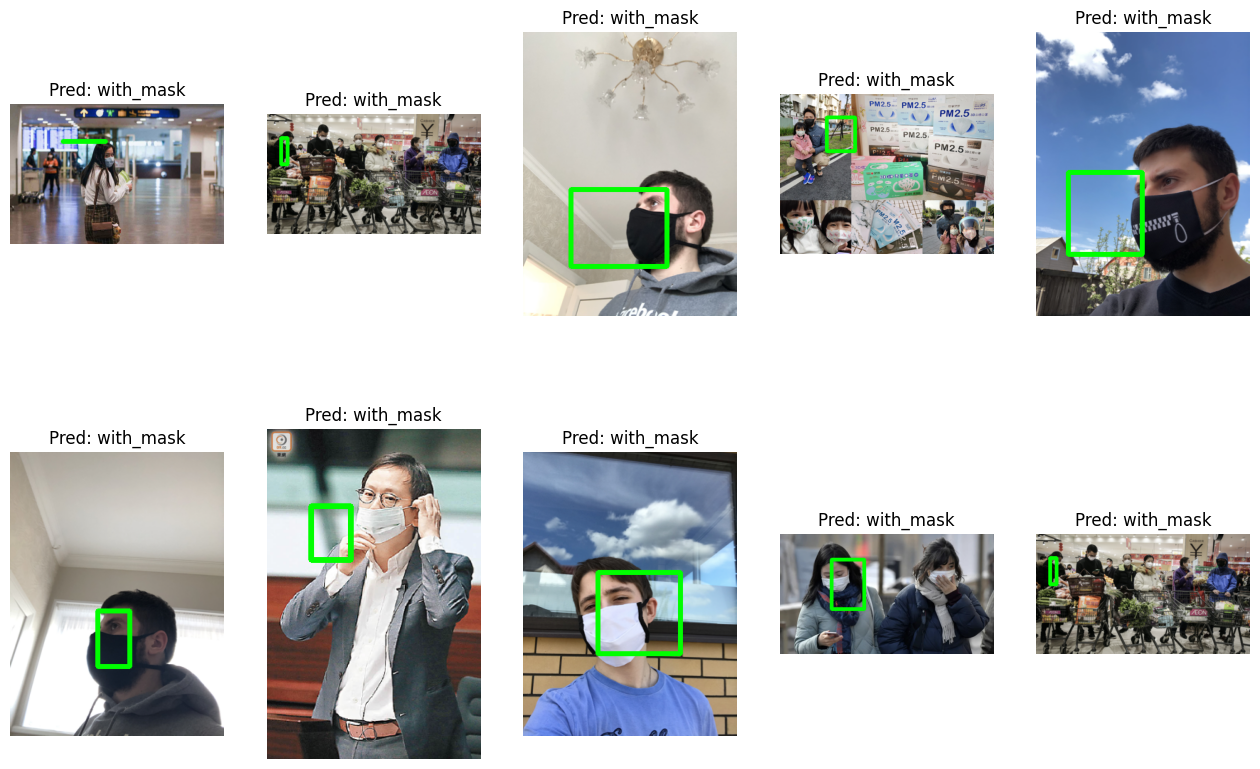

In [24]:
from sklearn.metrics import classification_report

def evaluate_and_visualize(model, X_test_paths, yc_true, yb_true):
    plt.figure(figsize=(16, 10))
    
    for i in range(10):
        idx = np.random.randint(0, len(X_test_paths))
        img = cv2.imread(X_test_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        
        blob = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        cls_p, box_p = model.predict(np.expand_dims(blob, axis=0))
        
        
        xmin, ymin, xmax, ymax = box_p[0]
        label = INV_LABELS[np.argmax(cls_p)]
        
        
        plt.subplot(2, 5, i+1)
        cv2.rectangle(img, (int(xmin*w), int(ymin*h)), (int(xmax*w), int(ymax*h)), (0, 255, 0), 5)
        plt.imshow(img)
        plt.title(f"Pred: {label}")
        plt.axis('off')
    
    plt.show()

evaluate_and_visualize(model, X_test, yc_test, yb_test)

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("models/mask_detector_quantized.tflite", "wb") as f:
    f.write(tflite_model)
print("Quantized Model Saved.")

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpuehq5lol\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpuehq5lol\assets


Quantized Model Saved.


In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score

def calculate_iou(boxA, boxB):
    """
    Calculate Intersection over Union (IoU) between two boxes.
    Box format: [xmin, ymin, xmax, ymax]
    """
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    
    interArea = max(0, xB - xA) * max(0, yB - yA)

   
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # IoU = Area of Overlap / Area of Union
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-7)
    return iou

def report_metrics_at_iou_50(model, test_ds, y_true_cls, y_true_box):
    """
    Prints mAP @ 0.5 and class-wise performance.
    """
    
    cls_preds, box_preds = model.predict(test_ds)
    
    class_names = ['With Mask', 'Without Mask', 'Incorrect']
    iou_threshold = 0.5
    
    per_class_correct = {0: 0, 1: 0, 2: 0}
    per_class_total = {0: 0, 1: 0, 2: 0}
    
    
    for i in range(len(box_preds)):
        true_label = np.argmax(y_true_cls[i])
        pred_label = np.argmax(cls_preds[i])
        
        iou = calculate_iou(y_true_box[i], box_preds[i])
        
        per_class_total[true_label] += 1
        
        
        if pred_label == true_label and iou >= iou_threshold:
            per_class_correct[true_label] += 1

    
    print("-" * 30)
    print(f"REPORT: Metrics at IoU = {iou_threshold}")
    print("-" * 30)
    
    overall_correct = 0
    for idx, name in enumerate(class_names):
        accuracy = per_class_correct[idx] / per_class_total[idx] if per_class_total[idx] > 0 else 0
        overall_correct += per_class_correct[idx]
        print(f"Class: {name:15} | Accuracy @ IoU 0.5: {accuracy:.2%}")
    
    mAP_50 = overall_correct / len(box_preds)
    print("-" * 30)
    print(f"Overall mAP @ 0.5: {mAP_50:.4f}")
    print("-" * 30)

In [29]:
report_metrics_at_iou_50(model, test_ds, yc_test, yb_test)

6/6 [==============================] - 1s 95ms/step
------------------------------
REPORT: Metrics at IoU = 0.5
------------------------------
Class: With Mask       | Accuracy @ IoU 0.5: 8.22%
Class: Without Mask    | Accuracy @ IoU 0.5: 4.17%
Class: Incorrect       | Accuracy @ IoU 0.5: 0.00%
------------------------------
Overall mAP @ 0.5: 0.0760
------------------------------
